In [7]:
import torch
a=torch.randn(15,6)
#torch.sum(a,dim=1)

In [175]:

from egnn_pytorch import EGNN_Network
import torch
import torch.nn as nn
import numpy as np
import glob
import time
import gzip
import math
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, dropout=0.1, max_len=500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float) *
                             (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        if embed_dim % 2 == 1:
            # Handle odd dimensions by filling the remaining column with cos()
            pe[:, 1::2] = torch.cos(position * div_term)[:, :pe[:, 1::2].shape[1]]
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # (max_len, 1, embed_dim)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: Tensor with shape (seq_length, batch_size, embed_dim)
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
    
class SimpleMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SimpleMultiheadAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
    
    def forward(self, x):
        """
        x: Tensor of shape (seq_length, batch_size, embed_dim)
        """
        attn_outputs, attn_weights = self.multihead_attn(x, x, x)
        return attn_outputs
    
import torch
import torch.nn as nn
import torch.nn.functional as F

class TinyRegressor(nn.Module):
    def __init__(self, in_channels=2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, 1, padding=1)
            #nn.ReLU(),
            #nn.Conv2d(16, 32, 3, padding=1),
            #nn.ReLU()
        #)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.out  = nn.Linear(1, 1)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x).flatten(1)   # (B, 32)
        return self.out(x)

       # (B, 1)
    
model = TinyRegressor()
#lin=nn.Linear(6,1)
A = PositionalEncoding(1)
mha = SimpleMultiheadAttention(2,1)

In [176]:
net=EGNN_Network(dim=2,
    depth=6,
    num_positions=500,
    num_tokens=78,
    num_edge_tokens=3,
    global_linear_attn_every=1,
    global_linear_attn_dim_head=8,
    num_global_tokens=2,
    adj_dim=3,
    fourier_features=2,
    m_dim=2,
    dropout=0.05)

#lin=nn.Linear(6,1)
A = PositionalEncoding(1)
mha = SimpleMultiheadAttention(2,1) #6 is the dim
tlosses, losses=[],[]
paths=np.char.array(glob.glob("/home/jrhoernschemeyer/Desktop/data_prep/inputs/*.npz"))
val=paths[np.random.random_integers(low=0,high=len(paths)-2,size=np.int(0.4*len(paths)))]
train=np.char.array(list(set(paths).difference(set(val))))
#np.savez_compressed("/home/jrhoernschemeyer/Desktop/data_prep/split.npz",val=val, train=train)

optimizer= torch.optim.Adam(list(net.parameters()) + list(mha.parameters()) + list(model.parameters()), lr=.01, weight_decay=0.01)
criterion = nn.HuberLoss()
to=time.time()
for i in range(1):
    #try:
    
    train = list(np.array(train)[np.random.permutation(len(train))])
    print("epoch",i)
    for path in train:
        losses=[]
        pdb=np.char.encode(path[-8:-4])
        mha.train()
        net.train()
        model.train()
        optimizer.zero_grad()
        a=np.load(path,allow_pickle=True)
        zs,xs,targets=a["z"],a["pos"],a["pks"]
        n = zs.shape[0]
        #shuffle
        idx = np.random.permutation(n)
        zs,xs,targets=zs[idx],xs[idx],targets[idx]
        
        for z,x,y in zip(zs,xs,targets):

            x=torch.tensor(x).unsqueeze(0)
            z=torch.tensor(z[0].astype(np.int32)).unsqueeze(0)

            #x=torch.tensor(list(x)).unsqueeze(0)
            #z=torch.tensor(list(z),dtype=torch.int32)
            #remove H
            #mask = (z != 1)
            #z = z[mask]
            #x = x[mask]

            out=net(z,x)
            x = mha(A(out[0][0]))          #  shape: (H, W, C) = (9, 9, 6)

            x = x.permute(2, 0, 1).unsqueeze(0)   # → (B, C, H, W) = (1, 6, 9, 9)

            pk = model(x)        
            #out=mha(A(out[0][0]))
            #out.permute(2, 0, 1).unsqueeze(0) 
            #pk=model(out)
            #print("why")
            loss = criterion(pk,torch.tensor(y))
            tlosses.append(np.round(loss.item(),3))
            loss.backward()
            optimizer.step()
            print(pk,loss)

            #pk=torch.sum(out[0],dim=1)/(torch.max(out[0]))
            #out=lin(pk)

    print(("validating. last loss", loss, time.time()-to)/60,"minutes")
    for path in val:
        mha.eval()
        net.eval()
        model.eval()

        a=np.load(path,allow_pickle=True)
        zs,xs,targets=a["z"],a["pos"],a["pks"]
        #n = zs.shape[0]
        #shuffle
        #idx = np.random.permutation(n)
        #zs,xs,targets=zs[idx],xs[idx],targets[idx]
        
        for z,x,y in zip(zs,xs,targets):
            
            x=torch.tensor(x).unsqueeze(0)
            z=torch.tensor(z[0].astype(np.int32)).unsqueeze(0)
            
            mask= z != 1
            z = z[mask]
            x = x[mask]
            oout=net(z,x)
            x = mha(A(out[0][0]))          #  shape: (H, W, C) = (9, 9, 6)

            x = x.permute(2, 0, 1).unsqueeze(0)   # → (B, C, H, W) = (1, 6, 9, 9)

            pk = model(x)
            loss = criterion(out,torch.tensor(y))
            losses.append(np.round(loss.item(),3))
            out=net(z,x)
            x = mha(A(out[0][0]))          #  shape: (H, W, C) = (9, 9, 6)

            x = x.permute(2, 0, 1).unsqueeze(0)   # → (B, C, H, W) = (1, 6, 9, 9)

            pk = model(x)        
            #out=mha(A(out[0][0]))
            #out.permute(2, 0, 1).unsqueeze(0) 
            #pk=model(out)
            #print("why")
            loss = criterion(pk,torch.tensor(y))
            losses.append(np.round(loss.item(),3))
            loss.backward()
            optimizer.step()
            print(pk,loss)

    #
                    
    #except Exception as e:
        #print("exception",e,pdb,z)
        #continue    
        #with gzip.open("/home/jrhoernschemeyer/Desktop/data_prep/valresultsfinal.gz","a") as f:
            #f.write(np.char.encode(str(np.round(np.mean(losses).item(),3))))
            #f.write(b" ")
            #f.close()
            

/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: This function is deprecated. Please call randint(0, 20993 + 1) instead
/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:972: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


epoch 0
tensor([[-0.2684]], grad_fn=<AddmmBackward0>) tensor(9.0046e-05, grad_fn=<HuberLossBackward0>)
tensor([[-0.2549]], grad_fn=<AddmmBackward0>) tensor(1.2545, grad_fn=<HuberLossBackward0>)
tensor([[-0.2332]], grad_fn=<AddmmBackward0>) tensor(1.7137, grad_fn=<HuberLossBackward0>)
tensor([[-0.2152]], grad_fn=<AddmmBackward0>) tensor(0.0046, grad_fn=<HuberLossBackward0>)
tensor([[-0.2136]], grad_fn=<AddmmBackward0>) tensor(5.3318, grad_fn=<HuberLossBackward0>)
tensor([[-0.1987]], grad_fn=<AddmmBackward0>) tensor(0.0095, grad_fn=<HuberLossBackward0>)
tensor([[-0.1905]], grad_fn=<AddmmBackward0>) tensor(0.9942, grad_fn=<HuberLossBackward0>)
tensor([[-0.1846]], grad_fn=<AddmmBackward0>) tensor(0.1083, grad_fn=<HuberLossBackward0>)
tensor([[-0.1781]], grad_fn=<AddmmBackward0>) tensor(0.0256, grad_fn=<HuberLossBackward0>)
tensor([[-0.1705]], grad_fn=<AddmmBackward0>) tensor(1.2344, grad_fn=<HuberLossBackward0>)
tensor([[-0.1604]], grad_fn=<AddmmBackward0>) tensor(1.4708, grad_fn=<HuberLos

KeyboardInterrupt: 

In [162]:
z

tensor([7, 6, 6, 8, 6, 6, 6, 6, 7], dtype=torch.int32)

In [161]:
net

EGNN_Network(
  (token_emb): Embedding(78, 2)
  (pos_emb): Embedding(500, 2)
  (edge_emb): Embedding(3, 0)
  (layers): ModuleList(
    (0): ModuleList(
      (0): GlobalLinearAttention(
        (norm_seq): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
        (norm_queries): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
        (attn1): Attention(
          (to_q): Linear(in_features=2, out_features=64, bias=False)
          (to_kv): Linear(in_features=2, out_features=128, bias=False)
          (to_out): Linear(in_features=64, out_features=2, bias=True)
        )
        (attn2): Attention(
          (to_q): Linear(in_features=2, out_features=64, bias=False)
          (to_kv): Linear(in_features=2, out_features=128, bias=False)
          (to_out): Linear(in_features=64, out_features=2, bias=True)
        )
        (ff): Sequential(
          (0): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=2, out_features=8, bias=True)
          (2)

In [119]:
def model_summary(model):
  print("model_summary")
  print()
  print("Layer_name"+"\t"*7+"Number of Parameters")
  print("="*100)
  model_parameters = [layer for layer in model.parameters() if layer.requires_grad]
  layer_name = [child for child in model.children()]
  j = 0
  total_params = 0
  print("\t"*10)
  for i in layer_name:
    print()
    param = 0
    try:
      bias = (i.bias is not None)
    except:
      bias = False  
    if not bias:
      param =model_parameters[j].numel()+model_parameters[j+1].numel()
      j = j+2
    else:
      param =model_parameters[j].numel()
      j = j+1
    print(str(i)+"\t"*3+str(param))
    total_params+=param
  print("="*100)
  print(f"Total Params:{total_params}")       

model_summary(net)


model_summary

Layer_name							Number of Parameters
										

Embedding(78, 6)			480

Embedding(500, 6)			3000

Embedding(2, 0)			12

ModuleList(
  (0): ModuleList(
    (0): GlobalLinearAttention(
      (norm_seq): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
      (norm_queries): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
      (attn1): Attention(
        (to_q): Linear(in_features=6, out_features=48, bias=False)
        (to_kv): Linear(in_features=6, out_features=96, bias=False)
        (to_out): Linear(in_features=48, out_features=6, bias=True)
      )
      (attn2): Attention(
        (to_q): Linear(in_features=6, out_features=48, bias=False)
        (to_kv): Linear(in_features=6, out_features=96, bias=False)
        (to_out): Linear(in_features=48, out_features=6, bias=True)
      )
      (ff): Sequential(
        (0): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=6, out_features=24, bias=True)
        (2): GELU()
        (3

In [154]:
net=EGNN_Network(dim=6,
    depth=10,
    num_positions=50,
    num_tokens=78,
    num_edge_tokens=2,
    global_linear_attn_every=1,
    global_linear_attn_dim_head=6,
    num_global_tokens=10,
    adj_dim=3,
    m_dim=10,
    fourier_features=5,
    dropout=0.3)
sum(stuff.numel() for stuff in list(net.parameters()) + list(mha.parameters()) + list(model.parameters()) if stuff.requires_grad)

51195

In [116]:
model_summary(model)


model_summary

Layer_name							Number of Parameters
										

Conv2d(6, 1, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))			6

AdaptiveAvgPool2d(output_size=(1, 1))			2

Linear(in_features=1, out_features=1, bias=True)			1
Total Params:9


In [117]:
model_summary(mha)

model_summary

Layer_name							Number of Parameters
										

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
)			126
Total Params:126


In [108]:
out=mha(A(out[0][0]))
out.permute(2, 0, 1).unsqueeze(0) 
pk=model(out)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [1, 6, 1, 1], but got 3-dimensional input of size [9, 9, 6] instead

In [31]:
mha = SimpleMultiheadAttention(6,1)

torch.Size([9, 9, 1])

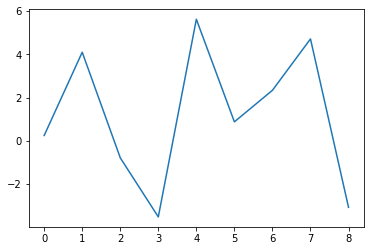

In [95]:
plt.plot(torch.sum(lin(mha(A(out[0][0]))),dim=0).detach().numpy())
lin2=nn.Linear(1,1)
lin2(lin(mha(A(out[0][0])))).shape



In [96]:
out[0].shape

torch.Size([1, 9, 6])

In [106]:

#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#criterion = nn.MSELoss()


In [107]:
x = mha(A(out[0][0]))          #  shape: (H, W, C) = (9, 9, 6)

x = x.permute(2, 0, 1).unsqueeze(0)   # → (B, C, H, W) = (1, 6, 9, 9)

pred = model(x)             


In [99]:
pred

tensor([[-0.0424]], grad_fn=<ReshapeAliasBackward0>)

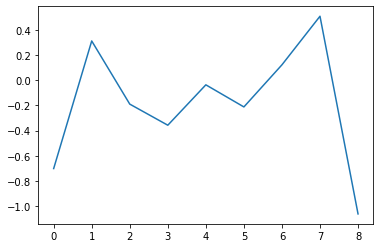

In [26]:
from matplotlib import pyplot as plt
plt.plot(torch.mean(out[0][0],dim=-1).detach().numpy())

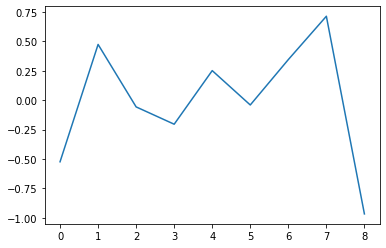

In [25]:
plt.plot(torch.mean(torch.mean(A(out[0][0]),dim=-1),dim=0).detach().numpy())

In [15]:
z
x
mask = (z != 1)
z = z[mask]
x = x[mask]


In [7]:
torch.sum(out[0][0],dim=0)

tensor([11.5851, -0.6893,  1.4510, -2.5218,  4.2458, -2.3039],
       grad_fn=<SumBackward1>)

In [10]:
torch.tensor(z[0].astype(np.int32))
(z != 1)
                #z = z[mask]
                #x = x[mask]

tensor([7, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 8], dtype=torch.int32)

In [47]:
b=A(out[0][0].unsqueeze(2))
c=mha(b)
d=torch.sum(mha(c),dim=-1)
e=lin(d)
torch.sum(e)/max(e)

tensor([5.5448], grad_fn=<DivBackward0>)

In [26]:
out[0][0].unsqueeze(2).shape

torch.Size([8, 6, 1])

In [50]:

from egnn_pytorch import EGNN_Network
import torch
import torch.nn as nn
import numpy as np
import glob
import time
import gzip
import math
with gzip.open("/home/jrhoernschemeyer/Desktop/data_prep/valresults_final.gz","wb") as f:
    #f.write(np.char.encode(str(np.round(np.mean(losses).item(),3))))
    f.write(b"0.00")
    f.close()
with gzip.open("/home/jrhoernschemeyer/Desktop/data_prep/trainresults_final.gz","wb") as f:
    #f.write(np.char.encode(str(np.round(np.mean(losses).item(),3))))
    f.write(b"0.00")
    f.close()
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, dropout=0.1, max_len=500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float) *
                             (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        if embed_dim % 2 == 1:
            # Handle odd dimensions by filling the remaining column with cos()
            pe[:, 1::2] = torch.cos(position * div_term)[:, :pe[:, 1::2].shape[1]]
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # (max_len, 1, embed_dim)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: Tensor with shape (seq_length, batch_size, embed_dim)
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
    
class SimpleMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SimpleMultiheadAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
    
    def forward(self, x):
        """
        x: Tensor of shape (seq_length, batch_size, embed_dim)
        """
        attn_outputs, attn_weights = self.multihead_attn(x, x, x)
        return attn_outputs


net=EGNN_Network(dim=6,
    depth=2,
    num_positions=500,
    num_tokens=200,
    num_nearest_neighbors=2, 
    num_edge_tokens=2,
    global_linear_attn_every=1,
    global_linear_attn_dim_head=6,
    num_global_tokens=2,
    adj_dim=3,
    fourier_features=5,
    m_dim=10,
    dropout=0.3)

lin=nn.Linear(6,1)
A = PositionalEncoding(22)
mha = SimpleMultiheadAttention(22,1)
losses=[]
paths=np.char.array(glob.glob("/home/jrhoernschemeyer/Desktop/data_prep/inputs/*.npz"))
val=paths[np.random.random_integers(low=0,high=len(paths)-2,size=np.int(0.4*len(paths)))][0:3]
train=np.char.array(list(set(paths).difference(set(val))))[0:3]
np.savez_compressed("/home/jrhoernschemeyer/Desktop/data_prep/split.npz",val=val, train=train)

optimizer= torch.optim.Adam(list(net.parameters()) + list(mha.parameters()) + list(lin.parameters()), lr=.01, weight_decay=0.01)
criterion = nn.HuberLoss()
to=time.time()

for i in range(25):
        train = list(np.array(train)[np.random.permutation(len(train))])
        print("epoch",i)
        for path in train:
            losses=[]
            pdb=np.char.encode(path[-8:-4])
            mha.train()
            net.train()
            lin.train()
            optimizer.zero_grad()
            a=np.load(path,allow_pickle=True)
            zs,xs,targets=a["z"],a["pos"],a["pks"]
            n = zs.shape[0]
            #shuffle
            idx = np.random.permutation(n)
            zs,xs,targets=zs[idx],xs[idx],targets[idx]
            
            for z,x,y in zip(zs,xs,targets):
                x=torch.tensor(list(x)).unsqueeze(0)
                z=torch.tensor(list(z),dtype=torch.int32)
                #remove H
                #mask = (z != 1)
                #z = z[mask]
                #x = x[mask]

                try:
                    out=net(z,x)[0][0].unsqueeze(2)
                    out=mha(A(out))
                    out=torch.sum(out,dim=-1)
                    out=lin(out)
                    out=torch.sum(out)

                    #y=torch.sum(out[0],dim=1)/(torch.max(out[0]))
                    
                    loss = criterion(out,torch.tensor(y))
                    losses.append(np.round(loss.item(),3))
                    loss.backward()
                    optimizer.step()
                #except:
                except Exception as e:
                    print("exception",e,pdb,z)
                    continue
                with gzip.open("/home/jrhoernschemeyer/Desktop/data_prep/trainresults_final.gz","a") as f:
                    f.write(np.char.encode(str(np.round(np.mean(losses),3))))
                    f.write(b" ")
                    f.close()
                
        for path in val:
            mha.eval()
            net.eval()
            lin.eval()
            print(2)

            a=np.load(path,allow_pickle=True)
            zs,xs,targets=a["z"],a["pos"],a["pks"]
            #n = zs.shape[0]
            #shuffle
            #idx = np.random.permutation(n)
            #zs,xs,targets=zs[idx],xs[idx],targets[idx]
            
            for z,x,y in zip(zs,xs,targets):
                x=torch.tensor(list(x)).unsqueeze(0)
                z=torch.tensor(list(z),dtype=torch.int32)
                try:
                    out=net(z,x)[0][0].unsqueeze(2)
                    out=mha(A(out))
                    out=torch.sum(out,dim=-1)
                    out=lin(out)
                    out=torch.sum(out)
                    loss = criterion(out,torch.tensor(y))
                    losses.append(np.round(loss.item(),3))
                        
                except Exception as e:
                    print("exception",e,pdb,z)
                    continue    
            with gzip.open("/home/jrhoernschemeyer/Desktop/data_prep/valresultsfinal.gz","a") as f:
                f.write(np.char.encode(str(np.round(np.mean(losses).item(),3))))
                f.write(b" ")
                f.close()
        print((time.time()-to)/60,"minutes")
            
            
        torch.save(net.state_dict(),"/home/jrhoernschemeyer/Desktop/data_prep/egnnfinal")
        torch.save(mha.state_dict(),"/home/jrhoernschemeyer/Desktop/data_prep/mhafinal")
        torch.save(mha.state_dict(),"/home/jrhoernschemeyer/Desktop/data_prep/mhafinal")#nettest")    


        
        

/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: This function is deprecated. Please call randint(0, 20993 + 1) instead


epoch 0
2
2
2
0.17205572923024495 minutes
epoch 1


KeyboardInterrupt: 

In [49]:
val

chararray(['/home/jrhoernschemeyer/Desktop/data_prep/inputs/2ybd.npz',
           '/home/jrhoernschemeyer/Desktop/data_prep/inputs/5r2h.npz',
           '/home/jrhoernschemeyer/Desktop/data_prep/inputs/3zpg.npz'],
          dtype='<U56')

In [27]:
out[0][0].shape

torch.Size([8, 6])